In [22]:
%matplotlib inline
from pymc3 import Model, sample, Normal, Uniform, MvNormal, LKJCorr, find_MAP, forestplot
import numpy as np
import theano.tensor as tt
from theano.tensor.nlinalg import matrix_inverse as inv
from numpy import array, diag, linspace
from numpy.random import multivariate_normal

# The LKJ (Lewandowski, Kurowicka and Joe) Distribution

The LKJ distribution is a prior distribution for correlation matrices. If n = 1 this corresponds to the uniform distribution over correlation matrices. As `n` approaches infinity, the LKJ prior approaches the identity matrix.

The support of the distribution is all upper triangular matrix with element values in [-1, 1].

PyMC3's implementation only returns the values of the upper triangular matrix, excluding the diagonal.

To demonstrate, we will generate some data from an arbitrary multivariate normal distribution, then try to recover its parameter values via a LKJ prior on the correlation matrix.

First, we generate some multivariate normal data:

In [13]:
n_obs = 1000

# Mean values:
mu = linspace(0, 2, num=4)
n_var = len(mu)

# Standard deviations:
stds = np.ones(4) / 2.0

# Correlation matrix of 4 variables:
corr = array([[1.,  0.75,  0.,  0.15],
              [0.75,  1., -0.06,  0.19],
              [0., -0.06,  1., -0.04],
              [0.15,  0.19, -0.04,  1.]])
cov_matrix = diag(stds).dot(corr.dot(diag(stds)))

dataset = multivariate_normal(mu, cov_matrix, size=n_obs)

In order to convert the upper triangular correlation values to a complete correlation matrix, we need to construct an index matrix.

In [14]:
n_elem = int(n_var * (n_var - 1) / 2)
tri_index = np.zeros([n_var, n_var], dtype=int)
tri_index[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

In [25]:
tri_index

array([[0, 0, 1, 2],
       [0, 0, 3, 4],
       [1, 3, 0, 5],
       [2, 4, 5, 0]])

The zeros on the diagonal will be replaced with variances.

In [18]:
with Model() as model:

    mu = Normal('mu', mu=0, tau=1 ** -2, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma = Uniform('sigma', shape=n_var)
    rho = LKJCorr('rho', n=1, p=n_var)
    
    # Construct matrix from sigma
    corr_matrix = rho[tri_index]
    corr_matrix = tt.fill_diagonal(corr_matrix, 1)
    cov_matrix = tt.diag(sigma).dot(corr_matrix.dot(tt.diag(sigma)))

    like = MvNormal('likelihood', mu=mu, tau=inv(cov_matrix), observed=dataset)


Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [19]:
with model:
    tr = sample(2000, start=find_MAP())

Assigned NUTS to mu
Assigned NUTS to sigma_interval_
Assigned NUTS to corr
 [-------100%-------] 2000 of 2000 in 28.8 sec. | SPS: 69.5 | ETA: 0.0

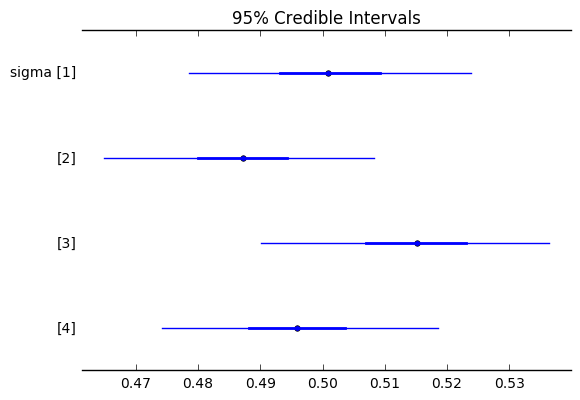

In [23]:
forestplot(tr, varnames=['sigma']);

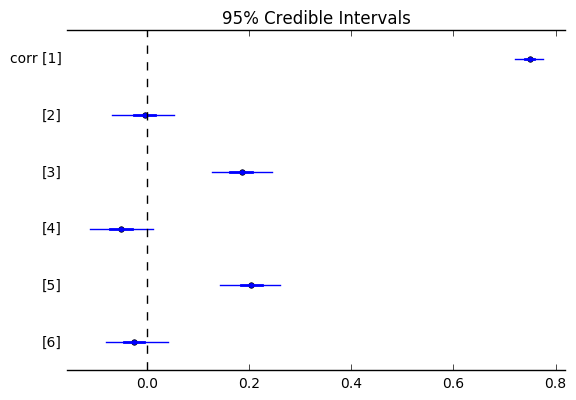

In [24]:
forestplot(tr, varnames=['rho']);

## References

1.	Lewandowski D, Kurowicka D, Joe H. Generating random correlation matrices based on vines and extended onion method. *Journal of Multivariate Analysis*. 2009;100(9):1989-2001. [doi:10.1016/j.jmva.2009.04.008.](http://www.sciencedirect.com/science/article/pii/S0047259X09000876)